In [1]:
import chardet
import numpy as np

def detect_encoding(file_path):
    '''检测文件的encoding方式'''
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']
        
def load_obj_file(file_path, encoding):
    '''读取obj文件中的点云坐标，输出是list'''
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces

def insert_midpoint_points(vertices, faces, minimum_vertices_number=3000):
    if len(vertices) >= minimum_vertices_number:
        print('原始点云的点数足够多')
        return vertices, faces

    else:
        temp = 0
        while len(vertices) < minimum_vertices_number:
            edge_to_midpoint = {}
            new_points = []
            new_faces = []
            vertex_offset = len(vertices)
    
            for face in faces:
                # Compute midpoints for each edge
                midpoints = []
                for i in range(len(face)):
                    edge = tuple(sorted((face[i], face[(i + 1) % len(face)])))
                    if edge not in edge_to_midpoint:
                        midpoint = np.mean([vertices[edge[0]], vertices[edge[1]]], axis=0)
                        edge_to_midpoint[edge] = vertex_offset + len(new_points)
                        new_points.append(midpoint.tolist())
                    midpoints.append(edge_to_midpoint[edge])
                
                # Original vertices
                v0, v1, v2 = face
                # Midpoints
                m0, m1, m2 = midpoints

                # Create four new faces
                new_faces.append([v0, m0, m2])
                new_faces.append([v1, m1, m0])
                new_faces.append([v2, m2, m1])
                new_faces.append([m0, m1, m2])
    
            vertices.extend(new_points)
            faces = new_faces
            temp += 1

        print(f'使用了 {temp} 轮插值来让点云点数满足要求')
        
    return vertices, faces

def center_vertices(vertices):
    '''将点云坐标系原点移动至其包围盒中心，输出是array'''
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices


In [2]:
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

def compute_bounding_box(points):
    """计算点云的包围盒"""
    min_point = np.min(points, axis=0)
    max_point = np.max(points, axis=0)
    bbox_size = max_point - min_point
    bbox_center = (min_point + max_point) / 2.0
    return bbox_size, bbox_center

def extract_top_subcloud(points, bbox_size, bbox_center, height=4.0):
    """提取y坐标在ymax到ymax-3范围内的子点云"""
    min_y = bbox_center[1] + bbox_size[1] / 2.0 - height
    top_subcloud = points[points[:, 1] >= min_y]
    return top_subcloud

def find_best_rotation(points, axis1, axis2, axis3, half_angle_range=int(90), angle_step=1):
    """绕axis1旋转，使得axis2（优先）、axis3方向包围盒尺寸最小，输出旋转矩阵"""
    min_size2 = float('inf')
    min_size3 = float('inf')
    best_rotation_matrix = None

    for angle in np.arange(-half_angle_range, half_angle_range, angle_step):
        # 绕指定轴旋转
        rotation_matrix = R.from_euler(axis1, angle, degrees=True).as_matrix()
        rotated_points = points.dot(rotation_matrix.T)
        
        # 计算包围盒尺寸
        bbox_size, _ = compute_bounding_box(rotated_points)
        
        # 找出目标轴之外的最小尺寸
        if axis2 == 'x':
            size2 = bbox_size[0]  # x方向宽度
        elif axis2 == 'y':
            size2 = bbox_size[1]  # z方向宽度
        elif axis2 == 'z':
            size2 = bbox_size[2]  # z方向宽度

        # 找出目标轴之外的最小尺寸
        if axis3 == 'x':
            size3 = bbox_size[0]  # x方向宽度
        elif axis3 == 'y':
            size3 = bbox_size[1]  # z方向宽度
        elif axis3 == 'z':
            size3 = bbox_size[2]  # z方向宽度

        # 如果当前尺寸比之前的最小尺寸还小，则更新
        if size2 < min_size2:
            min_size2 = size2
            min_size3 = size3
            best_rotation_matrix = rotation_matrix
        elif size2 == min_size2:
            if size3 <min_size3:
                min_size3 = size3
                best_rotation_matrix = rotation_matrix

    return best_rotation_matrix

def flatten_and_analyze_curve(points, x_threshold=0.3, y_offset=1.5):
    """在新y-z平面上分析曲线的曲率，并确定x、z方向。
    
    参数:
    - points: 点云数据，形状为 (n, 3)
    - x_threshold: 用于滤波的x坐标阈值
    - y_offset: 确定用于分裂曲线的横线 y=ymax-y_offset 的偏移量
    """
    # 提取平面内的点
    flat_points = points[np.abs(points[:, 0]) <= x_threshold]

    # 提取 y 和 z 坐标
    y_coords = flat_points[:, 1]
    z_coords = flat_points[:, 2]

    # 对 y_coords 和 z_coords 进行排序以确保 z_coords 严格递增
    sorted_indices = np.argsort(z_coords)
    z_coords = z_coords[sorted_indices]
    y_coords = y_coords[sorted_indices]

    # 确定 ymax - y_offset 这条横线
    ymax = np.max(y_coords)
    y_threshold = ymax - y_offset

    # 找到 y_coords 刚刚超过 y_threshold 的最小和最大索引
    above_threshold_indices = np.where(y_coords > y_threshold)[0]
    if len(above_threshold_indices) == 0:
        raise ValueError("没有点的y坐标超过指定的y_threshold")

    min_index = above_threshold_indices[0]
    max_index = above_threshold_indices[-1]

    # 使用这些索引作为左侧和右侧的分界点
    left_indices = np.where((y_coords <= y_threshold) & (z_coords <= z_coords[min_index]))[0]
    right_indices = np.where((y_coords <= y_threshold) & (z_coords >= z_coords[max_index]))[0]

    left_index = left_indices[np.argmin(np.abs(y_coords[left_indices] - y_threshold))]
    right_index = right_indices[np.argmin(np.abs(y_coords[right_indices] - y_threshold))]

    y2_left, z2_left = y_coords[left_index], z_coords[left_index]
    y2_right, z2_right = y_coords[right_index], z_coords[right_index]

    # 找到曲线的第一个点和最后一个点
    y1, z1 = y_coords[0], z_coords[0]
    y3, z3 = y_coords[-1], z_coords[-1]

    # 计算线段 (z1, y1)-(z2_left, y2_left) 和 (z2_right, y2_right)-(z3, y3) 的斜率
    slope_left = (y2_left - y1) / (z2_left - z1)
    slope_right = (y3 - y2_right) / (z3 - z2_right)

    # 计算两侧线段下方的点数占比
    left_side_points = flat_points[flat_points[:, 2] < z2_left]
    right_side_points = flat_points[flat_points[:, 2] >= z2_right]

    left_under_line = left_side_points[:, 1] < (slope_left * (left_side_points[:, 2] - z1) + y1)
    right_under_line = right_side_points[:, 1] < (slope_right * (right_side_points[:, 2] - z2_right) + y2_right)

    left_under_ratio = np.sum(left_under_line) / len(left_side_points)
    right_under_ratio = np.sum(right_under_line) / len(right_side_points)

    # 确定 z 方向：下凹一侧为 z 正方向
    '''如果最终结果的姿态是反的，就修改这里的正负号'''
    z_direction = -1 if left_under_ratio > right_under_ratio else 1

    # 复制相同的旋转给 z 方向以保持手性
    x_direction = z_direction

    return x_direction, z_direction

def align_point_cloud(points):
    """处理并旋转点云"""  
    # 计算原始点云的包围盒
    bbox_size, bbox_center = compute_bounding_box(points)

    # 提取顶端子点云1：较短，用于找到最扁取向
    top_subcloud1 = extract_top_subcloud(points, bbox_size, bbox_center, height=3.0)

    # 找到使得点云最扁的旋转角度
    best_rotation_matrix = find_best_rotation(top_subcloud1, 'y', 'z', 'x')

    # 提取顶端子点云2：较长，用于对比唇舌侧的凸性
    top_subcloud2 = extract_top_subcloud(points, bbox_size, bbox_center, height=5.0)
    
    # 将子点云旋转到最佳角度
    rotated_subcloud = top_subcloud2.dot(best_rotation_matrix.T)
    
    # 在新y-z平面上分析曲线并确定z轴方向
    x_direction, z_direction = flatten_and_analyze_curve(rotated_subcloud)

    # 确定最终旋转矩阵
    new_x_axis = best_rotation_matrix[:, 0] * x_direction
    new_y_axis = best_rotation_matrix[:, 1]
    new_z_axis = best_rotation_matrix[:, 2] * z_direction

    best_rotation_matrix_y = np.column_stack((new_x_axis, new_y_axis, new_z_axis))

    # 旋转整个原始点云到新的坐标系
    aligned_points = points.dot(best_rotation_matrix_y.T)

    # 在x轴上进行进一步优化旋转
    best_rotation_matrix_x = find_best_rotation(aligned_points, 'x', 'z', 'y', half_angle_range=int(30))
    aligned_points = aligned_points.dot(best_rotation_matrix_x.T)

    # 在z轴上进行进一步优化旋转
    best_rotation_matrix_z = find_best_rotation(aligned_points, 'z', 'x', 'y', half_angle_range=int(30))
    aligned_points = aligned_points.dot(best_rotation_matrix_z.T)

    # 最终的旋转矩阵
    final_rotation_matrix = best_rotation_matrix_y.T.dot(best_rotation_matrix_x.T).dot(best_rotation_matrix_z.T)

    return aligned_points, final_rotation_matrix

# 创建一个两行一列的子图布局
def plot_cloud_before_and_after_pose_adjustment(points, aligned_points, save_path = None, y_rotation_angle=0):
    """绘制结果"""

    # 绘图
    fig = plt.figure(figsize=(14, 7))

    # 在第一个子图中显示原始点云
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='.')
    # 旋转视角，将y轴竖直并绕y轴旋转
    ax1.view_init(elev=90, azim=y_rotation_angle)
    # 设置图例
    ax1.set_title('Original Point Cloud')
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_zlabel('Z axis')

    # 保持原始点云各轴比例一致
    max_range = np.array([points[:, 0].max() - points[:, 0].min(),
                          points[:, 1].max() - points[:, 1].min(),
                          points[:, 2].max() - points[:, 2].min()]).max() / 2.0

    mid_x = (points[:, 0].max() + points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max() + points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max() + points[:, 2].min()) * 0.5

    ax1.set_xlim(mid_x - max_range, mid_x + max_range)
    ax1.set_ylim(mid_y - max_range, mid_y + max_range)
    ax1.set_zlim(mid_z - max_range, mid_z + max_range)

    # 在第二个子图中显示对齐后的点云
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(aligned_points[:, 0], aligned_points[:, 1], aligned_points[:, 2], c='r', marker='.')
    # 旋转视角，将y轴竖直并绕y轴旋转
    ax2.view_init(elev=90, azim=y_rotation_angle)
    # 设置图例
    ax2.set_title('Aligned Point Cloud')
    ax2.set_xlabel('X axis')
    ax2.set_ylabel('Y axis')
    ax2.set_zlabel('Z axis')

    # 设置对齐后的点云的坐标轴范围，使得每个轴的单位长度相同
    max_range_aligned = np.array([aligned_points[:, 0].max() - aligned_points[:, 0].min(),
                                  aligned_points[:, 1].max() - aligned_points[:, 1].min(),
                                  aligned_points[:, 2].max() - aligned_points[:, 2].min()]).max() / 2.0

    mid_x_aligned = (aligned_points[:, 0].max() + aligned_points[:, 0].min()) * 0.5
    mid_y_aligned = (aligned_points[:, 1].max() + aligned_points[:, 1].min()) * 0.5
    mid_z_aligned = (aligned_points[:, 2].max() + aligned_points[:, 2].min()) * 0.5

    ax2.set_xlim(mid_x_aligned - max_range_aligned, mid_x_aligned + max_range_aligned)
    ax2.set_ylim(mid_y_aligned - max_range_aligned, mid_y_aligned + max_range_aligned)
    ax2.set_zlim(mid_z_aligned - max_range_aligned, mid_z_aligned + max_range_aligned)

    # 设置视角
    elev, azim = (180,0)
    ax1.view_init(elev=elev, azim=azim)  # Adjust these values as needed
    ax2.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax1.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1
    ax2.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1
    
    # 保存图像
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

    plt.close(fig)  # 关闭图像以释放内存

当前工作目录： C:\Users\HP
修改后的工作目录： D:\李娅宁\9月下旬项目重开
使用了 1 轮插值来让点云点数满足要求


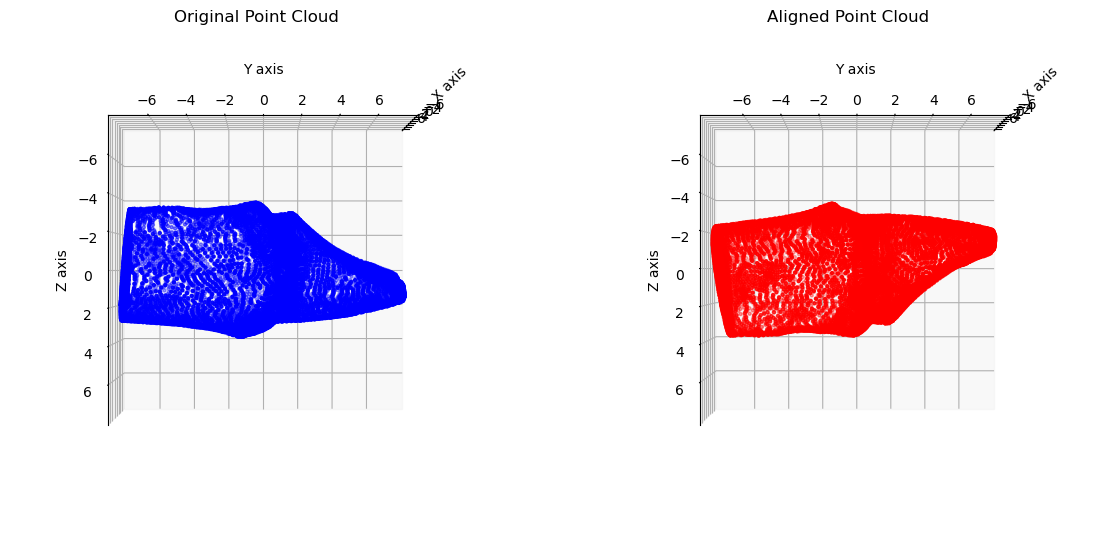

In [3]:
import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/李娅宁/9月下旬项目重开"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())

# 设置输入输出文件路径
obj_file_path = "标准牙/666.obj"

obj_encoding = detect_encoding(obj_file_path)
obj_vertices, obj_faces = load_obj_file(obj_file_path, obj_encoding)
checked_vertices, faces = insert_midpoint_points(obj_vertices, obj_faces, 5000)  # 对点数小于5000的点云做插值加密
centered_vertices = center_vertices(checked_vertices)

# 新姿态调整
aligned_points, final_rotation_matrix = align_point_cloud(centered_vertices)

# 对比姿态调整前后的点云
plot_cloud_before_and_after_pose_adjustment(centered_vertices, aligned_points)


In [4]:
# 读取并替换 OBJ 文件中的顶点
def replace_obj_vertices(obj_file_path, point_cloud, output_file_path):
    with open(obj_file_path, 'r') as obj_file:
        lines = obj_file.readlines()
    
    point_idx = 0
    with open(output_file_path, 'w') as new_obj_file:
        for line in lines:
            # 如果该行是顶点行（以 v 开头）
            if line.startswith('v '):
                # 替换顶点
                new_vertex = point_cloud[point_idx]
                new_line = f"v {new_vertex[0]} {new_vertex[1]} {new_vertex[2]}\n"
                new_obj_file.write(new_line)
                point_idx += 1
            else:
                # 保持其他行内容不变
                new_obj_file.write(line)


In [5]:
output_file_path = "标准牙/666姿态调整后.obj"
replace_obj_vertices(obj_file_path, aligned_points, output_file_path)

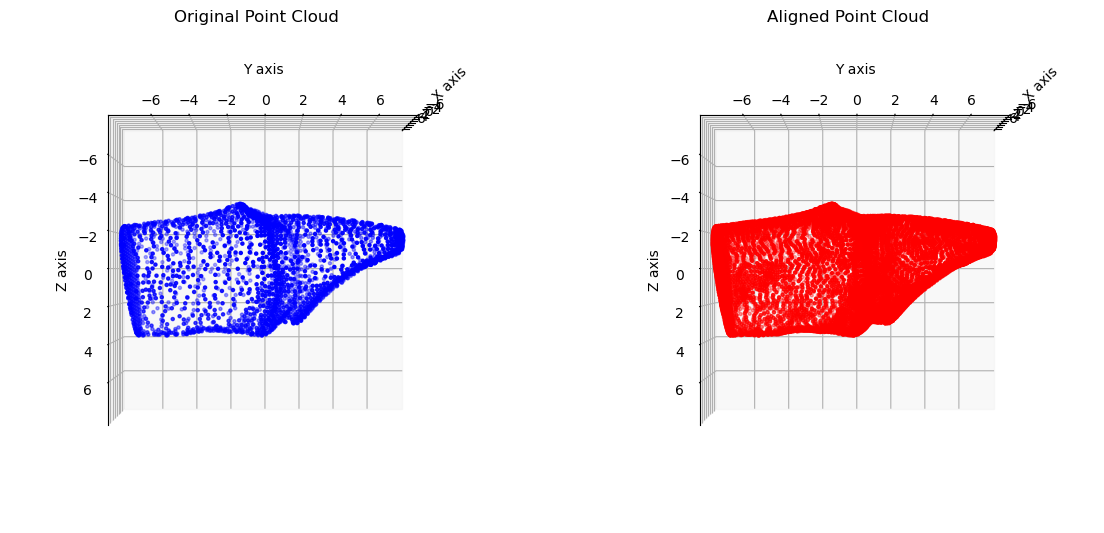

In [6]:
obj_encoding = detect_encoding(output_file_path)
obj_vertices, obj_faces = load_obj_file(output_file_path, obj_encoding)
obj_vertices = np.array(obj_vertices)
plot_cloud_before_and_after_pose_adjustment(obj_vertices, aligned_points)